In [17]:
import os

os.chdir("/".join(["D:", "Users", "nicol", "Documents", "Uni", "Master", "3rd Semester", "Thesis"]))
print(os.getcwd())

D:\Users\nicol\Documents\Uni\Master\3rd Semester\Thesis


In [18]:
from sklearn.metrics import accuracy_score
import tensorflow as tf
from lottery.Callbacks import FreezeCallback, LotteryCallback
from lottery.Combiner import *
from lottery.LotteryTicket import LotteryTicket
from lottery.optimizer.SGD import MaskingSGD
from lottery.Masker import *
from lottery.Models import *
from lottery.ModelSelector import *
from lottery.ExperimentSearch import ExperimentSearch

from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta, Adam, SGD

In [19]:
train, test = tf.keras.datasets.mnist.load_data()
train_images, train_labels = train
valid_test_images, valid_test_labels = test
train_images = train_images / 255.
valid_test_images = valid_test_images / 255.
valid_images = valid_test_images[:5000]
valid_labels = valid_test_labels[:5000]
test_images = valid_test_images[5000:]
test_labels = valid_test_labels[5000:]
print(train_images.shape, valid_images.shape, test_images.shape)
print(train_labels.shape, valid_labels.shape, test_labels.shape)

(60000, 28, 28) (5000, 28, 28) (5000, 28, 28)
(60000,) (5000,) (5000,)


In [20]:
def weights_0_percentage(model):
    for l in model.model.layers:
        if len(l.get_weights()) == 0:
            continue
        w = l.get_weights()[0]
        print(w.shape)
        print(sum(sum(w == 0)), " / ", (w.shape[0] * w.shape[1]))
        print(sum(sum(w == 0)) / (w.shape[0] * w.shape[1]))

In [ ]:
def log_args(fun):
    def inner(self, *args, **kwargs):
        print("{} called with args {} and kwargs {}".format(fun.__name__, args, kwargs.keys()))
        return fun(self, *args, **kwargs)
    return inner

In [21]:
epochs = 10
percentage = 78.9

In [22]:
class CheckSelectorCallback(LotteryCallback):
  def on_lottery_start(self, lt, current_model):
    print("-----------------------------------")
    print("Lottery:", lt.combiner, lt.selector)


  def on_marry_end(self, lt, current_model):
    weights_0_percentage(current_model)

In [ ]:
es = ExperimentSearch(keras.models.load_model("mnist_before_training_maskingsgd.h5", custom_objects={"MaskingSGD": MaskingSGD}),
                      MaskingSGD(),
                      sparse_categorical_crossentropy,
                      ['sparse_categorical_accuracy'],
                      [MaxMagCombiner(), MaxMagCombiner(FMagMasker, 79)],
                      [AnyDifferenceSelector(5, 2), AnyDifferenceSelector(10, 2), AnyDifferenceSelector(10, 4)],
                      [FMagMasker],
                      5,
                      percentage, "mnist", callbacks=[CheckSelectorCallback()])

es.fit(train_images, train_labels, validation_data=(valid_images, valid_labels), epochs=epochs, test_data=(test_images, test_labels))

-----------------------------------
Lottery: MaxMagCombiner(NonZeroMasker, None) AnyDifferenceSelector(5, 2, reverse=False)
25
mnist models/mnist\7
mnist models/mnist\62
mnist models/mnist\89
mnist models/mnist\125
mnist models/mnist\15
(784, 200)
97467  /  156800
0.6216007653061224
(200, 80)
9928  /  16000
0.6205
(80, 10)
499  /  800
0.62375
mnist models/mnist\71
mnist models/mnist\22
mnist models/mnist\55
mnist models/mnist\94
mnist models/mnist\60
(784, 200)
97613  /  156800
0.622531887755102
(200, 80)
9978  /  16000
0.623625
(80, 10)
506  /  800
0.6325
mnist models/mnist\122
mnist models/mnist\141
mnist models/mnist\39
mnist models/mnist\36
mnist models/mnist\70
(784, 200)
97680  /  156800
0.6229591836734694
(200, 80)
9959  /  16000
0.6224375
(80, 10)
495  /  800
0.61875
mnist models/mnist\84
mnist models/mnist\37
mnist models/mnist\65
mnist models/mnist\69
mnist models/mnist\91
(784, 200)
97578  /  156800
0.6223086734693878
(200, 80)
9949  /  16000
0.6218125
(80, 10)
502  /  800
0

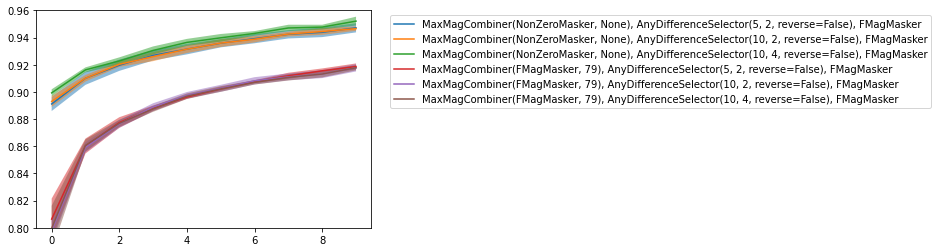

In [ ]:
es.plot_results(ylim=[0.8, 0.96], draw_org=False, draw_indices=[])

In [ ]:
es.results

{(<lottery.Combiner.MaxMagCombiner at 0x26f315e3910>,
  lottery.Masker.FMagMasker): <lottery.Models._HistoryWrapper at 0x26f2db358e0>,
 (<lottery.Combiner.MaxMagCombiner at 0x26f315e3910>,
  lottery.Masker.FMagMasker): <lottery.Models._HistoryWrapper at 0x26f3db1e8e0>,
 (<lottery.Combiner.MaxMagCombiner at 0x26f315e3910>,
  lottery.Masker.FMagMasker): <lottery.Models._HistoryWrapper at 0x26f3119de80>,
 (<lottery.Combiner.MaxMagCombiner at 0x26f315e3970>,
  lottery.Masker.FMagMasker): <lottery.Models._HistoryWrapper at 0x26f3dbbc340>,
 (<lottery.Combiner.MaxMagCombiner at 0x26f315e3970>,
  lottery.Masker.FMagMasker): <lottery.Models._HistoryWrapper at 0x26f2eba2e20>,
 (<lottery.Combiner.MaxMagCombiner at 0x26f315e3970>,
  lottery.Masker.FMagMasker): <lottery.Models._HistoryWrapper at 0x26f2daf6580>,
 (<lottery.Combiner.AvgCombiner at 0x26f315e3850>,
  lottery.Masker.FMagMasker): <lottery.Models._HistoryWrapper at 0x26f36ba3130>,
 (<lottery.Combiner.AvgCombiner at 0x26f315e3850>,
  lotte

In [ ]:
lt = LotteryTicket(keras.models.load_model("mnist_before_training_maskingsgd.h5", custom_objects={"MaskingSGD": MaskingSGD}),
                   MaskingSGD, sparse_categorical_crossentropy, ['sparse_categorical_accuracy'], combiner=DefaultCombiner(), iterations=5)
lt.set_pruner(FMagMasker)
lt.set_pruning_percentage(percentage)
lt.fit(train_images, train_labels, validation_data=(valid_images, valid_labels), epochs=10, test_data=(test_images, test_labels))
es.results[(lt.combiner, lt.selector, lt.pruner)] = lt.hist_experiment

5
mnist models/mnist\1
mnist models/mnist\4
mnist models/mnist\46
mnist models/mnist\8
mnist models/mnist\3


In [ ]:
es_everything_youll_ever_need = ExperimentSearch(keras.models.load_model("mnist_before_training_maskingsgd.h5", custom_objects={"MaskingSGD": MaskingSGD}),
                      MaskingSGD(),
                      sparse_categorical_crossentropy,
                      ['sparse_categorical_accuracy'],
                      [MaxMagCombiner(), MaxMagCombiner(FMagMasker, 79), AvgNoZeroCombiner(), MinWithoutZeroCombiner(), MaxWithoutZeroCombiner(), AddCombiner()],
                      [AnyDifferenceSelector(5, 2), AnyDifferenceSelector(10, 2), AnyDifferenceSelector(10, 4)],
                      [FMagMasker],
                      5,
                      percentage, "mnist", callbacks=[CheckSelectorCallback()])

es_everything_youll_ever_need.fit(train_images, train_labels, validation_data=(valid_images, valid_labels), epochs=epochs, test_data=(test_images, test_labels))

lt = LotteryTicket(keras.models.load_model("mnist_before_training_maskingsgd.h5", custom_objects={"MaskingSGD": MaskingSGD}),
                   MaskingSGD, sparse_categorical_crossentropy, ['sparse_categorical_accuracy'], combiner=DefaultCombiner(), iterations=5)
lt.set_pruner(FMagMasker)
lt.set_pruning_percentage(percentage)
lt.fit(train_images, train_labels, validation_data=(valid_images, valid_labels), epochs=10, test_data=(test_images, test_labels))
es_everything_youll_ever_need.results[(lt.combiner, lt.selector, lt.pruner)] = lt.hist_experiment

-----------------------------------
Lottery: MaxMagCombiner(NonZeroMasker, None) AnyDifferenceSelector(5, 2, reverse=False)
25
mnist models/mnist\29
mnist models/mnist\20
mnist models/mnist\38
mnist models/mnist\12
mnist models/mnist\24
<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(784, 200)
97696  /  156800
0.623061224489796
(200, 80)
9954  /  16000
0.622125
(80, 10)
496  /  800
0.62
mnist models/mnist\32
mnist models/mnist\40
mnist models/mnist\47
mnist models/mnist\10
mnist models/mnist\23
<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(784, 200)
97566  /  156800
0.6222321428571429
(200, 80)
9967  /  16000
0.6229375
(80, 10)
507  /  800
0.63375
mnist models/mnist\31
mnist models/mnist\26
mnist mo

D:\Users\nicol\Documents\Uni\Master\3rd Semester\Thesis\lottery\Combiner.py:172: RuntimeWarning: Mean of empty slice
  return np.nan_to_num(np.nanmean(weight_array, axis=0))


(784, 200)
97566  /  156800
0.6222321428571429
(200, 80)
9967  /  16000
0.6229375
(80, 10)
507  /  800
0.63375
mnist models/mnist\20
mnist models/mnist\4
mnist models/mnist\36
mnist models/mnist\34
mnist models/mnist\31
(784, 200)
97668  /  156800
0.6228826530612245
(200, 80)
9912  /  16000
0.6195
(80, 10)
504  /  800
0.63
mnist models/mnist\21
mnist models/mnist\12
mnist models/mnist\7
mnist models/mnist\39
mnist models/mnist\46
(784, 200)
97615  /  156800
0.6225446428571428
(200, 80)
9919  /  16000
0.6199375
(80, 10)
507  /  800
0.63375
mnist models/mnist\42
mnist models/mnist\38
mnist models/mnist\11
mnist models/mnist\41
mnist models/mnist\33
(784, 200)
97636  /  156800
0.6226785714285714
(200, 80)
9911  /  16000
0.6194375
(80, 10)
502  /  800
0.6275
mnist models/mnist\5
mnist models/mnist\14
mnist models/mnist\37
mnist models/mnist\1
mnist models/mnist\17
(784, 200)
97481  /  156800
0.6216900510204082
(200, 80)
9990  /  16000
0.624375
(80, 10)
517  /  800
0.64625
-----------------

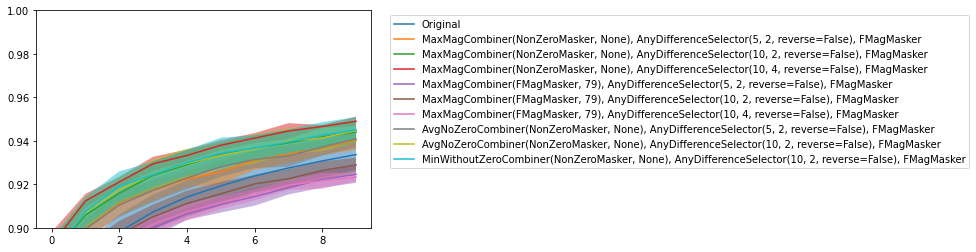

In [ ]:
es_everything_youll_ever_need.plot_results(draw_org=True, draw_indices=[0, 1, 2, 3, 4, 5, 6, 7, 10])

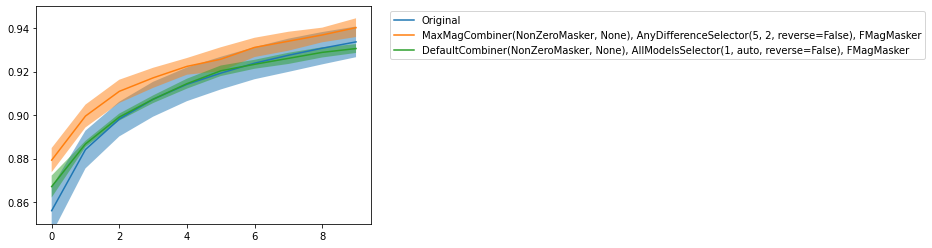

In [ ]:
es_everything_youll_ever_need.plot_results(ylim=[.85, .95], draw_indices=[0, 18])

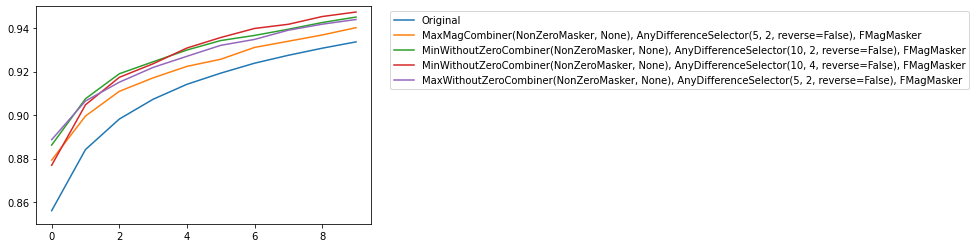

In [ ]:
es_everything_youll_ever_need.plot_results(ylim=[.85, .95], draw_std=False, draw_indices=[0, 10, 11, 12])

In [ ]:
es_other_combiners = ExperimentSearch(keras.models.load_model("mnist_before_training_maskingsgd.h5", custom_objects={"MaskingSGD": MaskingSGD}),
                      MaskingSGD(),
                      sparse_categorical_crossentropy,
                      ['sparse_categorical_accuracy'],
                      [DefaultCombiner(), AvgNoZeroCombiner(), MinWithoutZeroCombiner(), MaxWithoutZeroCombiner(), AddCombiner()],
                      [AnyDifferenceSelector(10, 4)],
                      [FMagMasker],
                      5,
                      percentage, "mnist", callbacks=[CheckSelectorCallback()])

es_other_combiners.fit(train_images, train_labels, validation_data=(valid_images, valid_labels), epochs=epochs, test_data=(test_images, test_labels))

lt = LotteryTicket(keras.models.load_model("mnist_before_training_maskingsgd.h5", custom_objects={"MaskingSGD": MaskingSGD}),
                   MaskingSGD, sparse_categorical_crossentropy, ['sparse_categorical_accuracy'], combiner=DefaultCombiner(), iterations=5)
lt.set_pruner(FMagMasker)
lt.set_pruning_percentage(40)
lt.fit(train_images, train_labels, validation_data=(valid_images, valid_labels), epochs=10, test_data=(test_images, test_labels))
es_other_combiners.results[(lt.combiner, lt.selector, lt.pruner)] = lt.hist_experiment

-----------------------------------
Lottery: DefaultCombiner(NonZeroMasker, None) AnyDifferenceSelector(10, 4, reverse=False)
50
mnist models/mnist\34
mnist models/mnist\35
mnist models/mnist\80
mnist models/mnist\133
mnist models/mnist\132
mnist models/mnist\53
mnist models/mnist\126
mnist models/mnist\24
mnist models/mnist\121
mnist models/mnist\103
(784, 200)
123715  /  156800
0.7889987244897959
(200, 80)
12624  /  16000
0.789
(80, 10)
631  /  800
0.78875
mnist models/mnist\82
mnist models/mnist\131
mnist models/mnist\67
mnist models/mnist\44
mnist models/mnist\81
mnist models/mnist\144
mnist models/mnist\65
mnist models/mnist\54
mnist models/mnist\71
mnist models/mnist\29
(784, 200)
123715  /  156800
0.7889987244897959
(200, 80)
12624  /  16000
0.789
(80, 10)
631  /  800
0.78875
mnist models/mnist\128
mnist models/mnist\138
mnist models/mnist\123
mnist models/mnist\95
mnist models/mnist\139
mnist models/mnist\4
mnist models/mnist\27
mnist models/mnist\11
mnist models/mnist\61
mnist

D:\Users\nicol\Documents\Uni\Master\3rd Semester\Thesis\lottery\Combiner.py:170: RuntimeWarning: Mean of empty slice
  return np.nan_to_num(np.nanmean(weight_array, axis=0))


(784, 200)
60795  /  156800
0.38772321428571427
(200, 80)
6187  /  16000
0.3866875
(80, 10)
315  /  800
0.39375
mnist models/mnist\136
mnist models/mnist\80
mnist models/mnist\131
mnist models/mnist\103
mnist models/mnist\19
mnist models/mnist\7
mnist models/mnist\89
mnist models/mnist\84
mnist models/mnist\91
mnist models/mnist\113
(784, 200)
60793  /  156800
0.3877104591836735
(200, 80)
6207  /  16000
0.3879375
(80, 10)
314  /  800
0.3925
mnist models/mnist\38
mnist models/mnist\28
mnist models/mnist\23
mnist models/mnist\77
mnist models/mnist\98
mnist models/mnist\59
mnist models/mnist\54
mnist models/mnist\42
mnist models/mnist\46
mnist models/mnist\122
(784, 200)
60808  /  156800
0.3878061224489796
(200, 80)
6167  /  16000
0.3854375
(80, 10)
309  /  800
0.38625
mnist models/mnist\143
mnist models/mnist\110
mnist models/mnist\123
mnist models/mnist\146
mnist models/mnist\11
mnist models/mnist\115
mnist models/mnist\48
mnist models/mnist\2
mnist models/mnist\86
mnist models/mnist\68

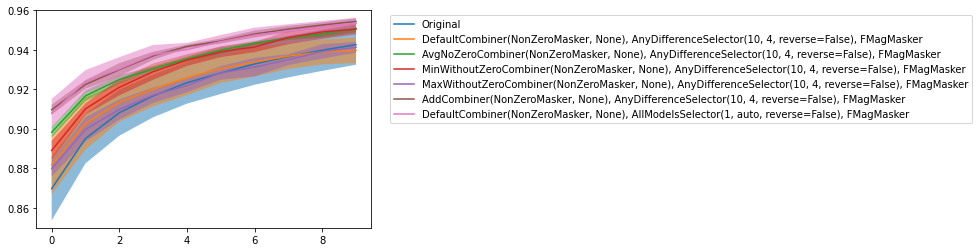

In [ ]:
es_other_combiners.plot_results(ylim=[.85, .96])

In [ ]:
es_max_min = ExperimentSearch(keras.models.load_model("mnist_before_training_maskingsgd.h5", custom_objects={"MaskingSGD": MaskingSGD}),
                      MaskingSGD(),
                      sparse_categorical_crossentropy,
                      ['sparse_categorical_accuracy'],
                      [MaxMagCombiner(), MaxWithoutZeroCombiner(), MinWithoutZeroCombiner()],
                      [AnyDifferenceSelector(10, 4)],
                      [FMagMasker],
                      5,
                      percentage, "mnist", callbacks=[CheckSelectorCallback()])

es_max_min.fit(train_images, train_labels, validation_data=(valid_images, valid_labels), epochs=epochs, test_data=(test_images, test_labels))

-----------------------------------
Lottery: MaxMagCombiner(NonZeroMasker, None) AnyDifferenceSelector(10, 4, reverse=False)
50
mnist models/mnist\2
mnist models/mnist\104
mnist models/mnist\47
mnist models/mnist\40
mnist models/mnist\109
mnist models/mnist\28
mnist models/mnist\38
mnist models/mnist\146
mnist models/mnist\25
mnist models/mnist\8
<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(784, 200)
60829  /  156800
0.3879400510204082
(200, 80)
6186  /  16000
0.386625
(80, 10)
305  /  800
0.38125
mnist models/mnist\34
mnist models/mnist\79
mnist models/mnist\112
mnist models/mnist\37
mnist models/mnist\125
mnist models/mnist\147
mnist models/mnist\90
mnist models/mnist\3
mnist models/mnist\137
mnis

In [ ]:
es_max_min.plot_results()

In [14]:
es_modular = ExperimentSearch(keras.models.load_model("mnist_before_training_maskingsgd.h5", custom_objects={"MaskingSGD": MaskingSGD}),
                      MaskingSGD(),
                      sparse_categorical_crossentropy,
                      ['sparse_categorical_accuracy'],
                      [MaxMagCombiner(), AvgNoZeroCombiner(), AddCombiner()],
                      [AnyDifferenceSelector(15, 5)],
                      [FMagMasker],
                      5,
                      95, "mnist", callbacks=[CheckSelectorCallback()])

es_modular.fit(train_images, train_labels, validation_data=(valid_images, valid_labels), epochs=epochs, test_data=(test_images, test_labels))

-----------------------------------
Lottery: MaxMagCombiner(NonZeroMasker, None) AnyDifferenceSelector(15, 5, reverse=False)
75
mnist models/mnist\32
mnist models/mnist\66
mnist models/mnist\16
mnist models/mnist\142
mnist models/mnist\26
mnist models/mnist\92
mnist models/mnist\94
mnist models/mnist\12
mnist models/mnist\63
mnist models/mnist\138
mnist models/mnist\140
mnist models/mnist\17
mnist models/mnist\117
mnist models/mnist\121
mnist models/mnist\139
(784, 200)
123196  /  156800
0.7856887755102041
(200, 80)
12389  /  16000
0.7743125
(80, 10)
620  /  800
0.775
mnist models/mnist\53
mnist models/mnist\97
mnist models/mnist\35
mnist models/mnist\80
mnist models/mnist\104
mnist models/mnist\90
mnist models/mnist\147
mnist models/mnist\62
mnist models/mnist\59
mnist models/mnist\11
mnist models/mnist\148
mnist models/mnist\51
mnist models/mnist\100
mnist models/mnist\39
mnist models/mnist\25
(784, 200)
123179  /  156800
0.7855803571428571
(200, 80)
12390  /  16000
0.774375
(80, 10)

D:\Users\nicol\Documents\Uni\Master\3rd Semester\Thesis\lottery\Combiner.py:170: RuntimeWarning: Mean of empty slice
  return np.nan_to_num(np.nanmean(weight_array, axis=0))


(784, 200)
123063  /  156800
0.7848405612244898
(200, 80)
12391  /  16000
0.7744375
(80, 10)
623  /  800
0.77875
mnist models/mnist\16
mnist models/mnist\86
mnist models/mnist\125
mnist models/mnist\1
mnist models/mnist\68
mnist models/mnist\11
mnist models/mnist\4
mnist models/mnist\65
mnist models/mnist\19
mnist models/mnist\43
mnist models/mnist\64
mnist models/mnist\132
mnist models/mnist\122
mnist models/mnist\12
mnist models/mnist\70
(784, 200)
123081  /  156800
0.7849553571428571
(200, 80)
12363  /  16000
0.7726875
(80, 10)
619  /  800
0.77375
mnist models/mnist\116
mnist models/mnist\55
mnist models/mnist\8
mnist models/mnist\105
mnist models/mnist\31
mnist models/mnist\44
mnist models/mnist\49
mnist models/mnist\33
mnist models/mnist\100
mnist models/mnist\134
mnist models/mnist\109
mnist models/mnist\75
mnist models/mnist\57
mnist models/mnist\96
mnist models/mnist\32
(784, 200)
123123  /  156800
0.7852232142857143
(200, 80)
12361  /  16000
0.7725625
(80, 10)
620  /  800
0.77

In [15]:
lt = LotteryTicket(keras.models.load_model("mnist_before_training_maskingsgd.h5", custom_objects={"MaskingSGD": MaskingSGD}),
                   MaskingSGD, sparse_categorical_crossentropy, ['sparse_categorical_accuracy'], combiner=DefaultCombiner(), iterations=5, callbacks=[CheckSelectorCallback()])
lt.set_pruner(FMagMasker)
lt.set_pruning_percentage(percentage)
lt.fit(train_images, train_labels, validation_data=(valid_images, valid_labels), epochs=10, test_data=(test_images, test_labels))
es_modular.results[(lt.combiner, lt.selector, lt.pruner)] = lt.hist_experiment

-----------------------------------
Lottery: DefaultCombiner(NonZeroMasker, None) AllModelsSelector(1, auto, reverse=False)
5
mnist models/mnist\82
(784, 200)
123715  /  156800
0.7889987244897959
(200, 80)
12624  /  16000
0.789
(80, 10)
631  /  800
0.78875
mnist models/mnist\41
(784, 200)
123715  /  156800
0.7889987244897959
(200, 80)
12624  /  16000
0.789
(80, 10)
631  /  800
0.78875
mnist models/mnist\63
(784, 200)
123715  /  156800
0.7889987244897959
(200, 80)
12624  /  16000
0.789
(80, 10)
631  /  800
0.78875
mnist models/mnist\102
(784, 200)
123715  /  156800
0.7889987244897959
(200, 80)
12624  /  16000
0.789
(80, 10)
631  /  800
0.78875
mnist models/mnist\116
(784, 200)
123715  /  156800
0.7889987244897959
(200, 80)
12624  /  16000
0.789
(80, 10)
631  /  800
0.78875


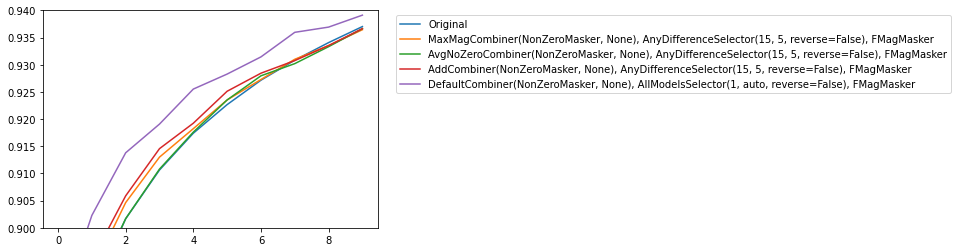

In [ ]:
es_modular.plot_results(ylim=[0.9, 0.94], draw_org=True, draw_std=False, draw_indices=[])

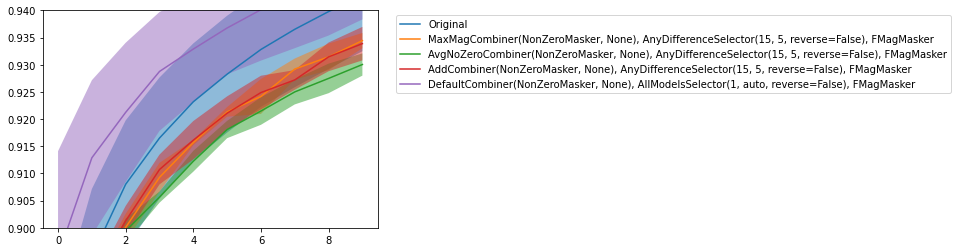

In [16]:
es_modular.plot_results(ylim=[0.9, 0.94], draw_org=True, draw_std=True, draw_indices=[])

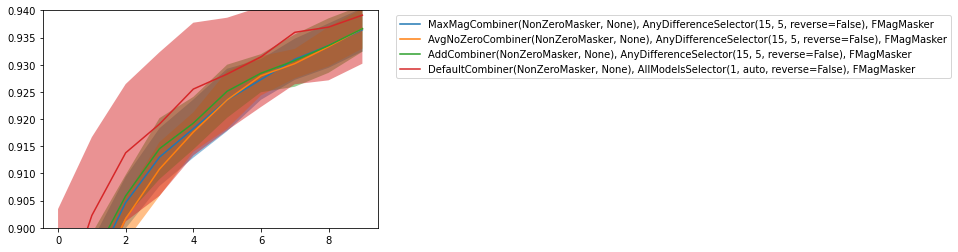

In [ ]:
es_modular.plot_results(ylim=[0.9, 0.94], draw_org=False, draw_std=True, draw_indices=[0, 1, 2, 3])

In [ ]:
es = ExperimentSearch(keras.models.load_model("mnist_before_training_maskingsgd.h5", custom_objects={"MaskingSGD": MaskingSGD}),
                      MaskingSGD(),
                      sparse_categorical_crossentropy,
                      ['sparse_categorical_accuracy'],
                      [DefaultCombiner(), MaxMagCombiner()],
                      [AnyDifferenceSelector(5, 2), AnyDifferenceSelector(10, 4)],
                      [FMagMasker],
                      5,
                      percentage, "mnist")

es.fit(train_images, train_labels, validation_data=(valid_images, valid_labels), epochs=epochs, test_data=(test_images, test_labels))

25
mnist models/mnist\48
mnist models/mnist\1
mnist models/mnist\3
mnist models/mnist\14
mnist models/mnist\24
mnist models/mnist\19
mnist models/mnist\8
mnist models/mnist\62
mnist models/mnist\34
mnist models/mnist\35
mnist models/mnist\39
mnist models/mnist\60
mnist models/mnist\46
mnist models/mnist\2
mnist models/mnist\69
mnist models/mnist\55
mnist models/mnist\72
mnist models/mnist\25
mnist models/mnist\7
mnist models/mnist\65
mnist models/mnist\64
mnist models/mnist\4
mnist models/mnist\21
mnist models/mnist\12
mnist models/mnist\17
50
mnist models/mnist\24
mnist models/mnist\11
mnist models/mnist\45
mnist models/mnist\64
mnist models/mnist\6
mnist models/mnist\1
mnist models/mnist\59
mnist models/mnist\70
mnist models/mnist\72
mnist models/mnist\36
mnist models/mnist\17
mnist models/mnist\57
mnist models/mnist\9
mnist models/mnist\15
mnist models/mnist\23
mnist models/mnist\74
mnist models/mnist\31
mnist models/mnist\27
mnist models/mnist\40
mnist models/mnist\3
mnist models/m

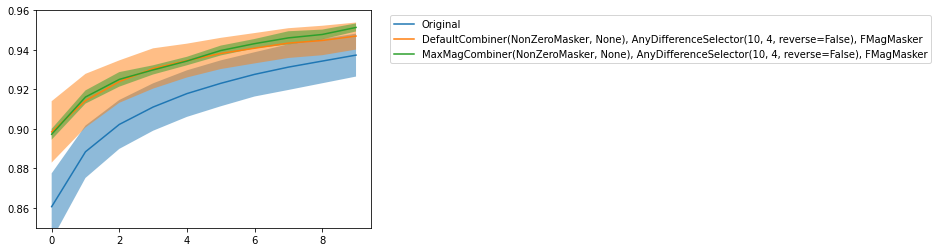

In [ ]:
es.plot_results(ylim=[.85, .96], draw_org=True, draw_std=True, draw_indices=[1, 3])

In [ ]:
es = ExperimentSearch(keras.models.load_model("mnist_before_training_maskingsgd.h5", custom_objects={"MaskingSGD": MaskingSGD}),
                      MaskingSGD(),
                      sparse_categorical_crossentropy,
                      ['sparse_categorical_accuracy'],
                      [MaxMagCombiner(), MaxMagCombiner(FMagMasker, 79)],
                      [AnyDifferenceSelector(5, 2), AnyDifferenceSelector(10, 2), AnyDifferenceSelector(10, 4)],
                      [FMagMasker],
                      5,
                      percentage, "mnist")

es.fit(train_images, train_labels, validation_data=(valid_images, valid_labels), epochs=epochs, test_data=(test_images, test_labels))

25
mnist models/mnist\30
mnist models/mnist\59
mnist models/mnist\85
mnist models/mnist\72
mnist models/mnist\82
<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
mnist models/mnist\143
mnist models/mnist\134
mnist models/mnist\63
mnist models/mnist\91
mnist models/mnist\57
<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
mnist models/mnist\28
mnist models/mnist\52
mnist models/mnist\132
mnist models/mnist\142
mnist models/mnist\34
<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
mnist models/mnist\75
mnist models/mnist\11
mnist models/mnist\49
mnist models/mnist\39

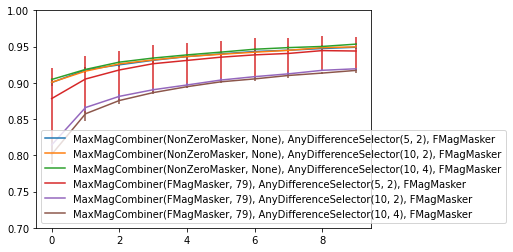

In [ ]:
# Reset weights before selecting
es.plot_results(ylim=[0.7, 1])

In [ ]:
es_many_siblings = ExperimentSearch(keras.models.load_model("mnist_before_training_maskingsgd.h5", custom_objects={"MaskingSGD": MaskingSGD}),
                      MaskingSGD(),
                      sparse_categorical_crossentropy,
                      ['sparse_categorical_accuracy'],
                      [MaxMagCombiner()],
                      [AnyDifferenceSelector(30, 4), AnyDifferenceSelector(30, 4, True)],
                      [FMagMasker],
                      5,
                      percentage,
                      "mnist",
                      callbacks=[CheckSelectorCallback()])
es_many_siblings.fit(train_images, train_labels, validation_data=(valid_images, valid_labels), epochs=epochs, test_data=(test_images, test_labels))

-----------------------------------
Lottery: MaxMagCombiner(NonZeroMasker, None) AnyDifferenceSelector(30, 4, reverse=False)
150
<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(784, 200)
60706  /  156800
0.387155612244898
(200, 80)
6156  /  16000
0.38475
(80, 10)
324  /  800
0.405
<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(784, 200)
60771  /  156800
0.3875701530612245
(200, 80)
6153  /  16000
0.3845625
(80, 10)
35

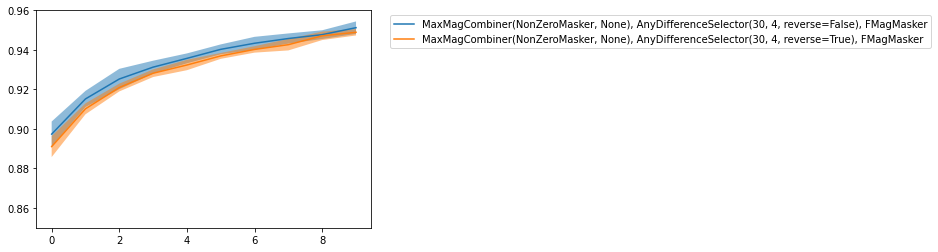

In [ ]:
es_many_siblings.plot_results(ylim=[.85, .96], draw_org=False)

In [ ]:
for c, s, p in es.results:
  print(c, s, p)
  l = es.results.get((c, s, p))
  for m in l.io.models:
    if m.refit_:
      l.evaluate(m.model, test_data=(test_images, test_labels))
  print("-----------------------------------")
  del l
  del c, s, p

MaxMagCombiner(NonZeroMasker, None) AnyDifferenceSelector(5, 2) <class 'lottery.Masker.FMagMasker'>
157/157 [==============================] - 0s 1ms/step
0.9772
157/157 [==============================] - 0s 1ms/step
0.9756
157/157 [==============================] - 0s 1ms/step
0.9774
157/157 [==============================] - 0s 1ms/step
0.9776
157/157 [==============================] - 0s 1ms/step
0.9766
-----------------------------------
MaxMagCombiner(NonZeroMasker, None) AnyDifferenceSelector(10, 2) <class 'lottery.Masker.FMagMasker'>
157/157 [==============================] - 0s 1ms/step
0.9774
157/157 [==============================] - 0s 1ms/step
0.9772
157/157 [==============================] - 0s 1ms/step
0.9756
157/157 [==============================] - 0s 1ms/step
0.9758
157/157 [==============================] - 0s 1ms/step
0.9768
-----------------------------------
MaxMagCombiner(NonZeroMasker, None) AnyDifferenceSelector(10, 4) <class 'lottery.Masker.FMagMasker'>
157/15

In [ ]:
esweird = ExperimentSearchWeird(keras.models.load_model("mnist_before_training.h5"),
                      SGD(),
                      sparse_categorical_crossentropy,
                      ['sparse_categorical_accuracy'],
                      [MaxMagCombiner(), MaxMagCombiner(FMagMasker, 79)],
                      [AnyDifferenceSelector(5, 2), AnyDifferenceSelector(10, 2), AnyDifferenceSelector(10, 4)],
                      [FMagMasker],
                      5,
                      percentage)

esweird.fit(train_images, train_labels, validation_data=(valid_images, valid_labels), epochs=epochs, test_data=(test_images, test_labels))

25
mnist models/mnist\14
mnist models/mnist\47
mnist models/mnist\26
mnist models/mnist\33
mnist models/mnist\41
mnist models/mnist\49
mnist models/mnist\16
mnist models/mnist\23
mnist models/mnist\21
mnist models/mnist\36
mnist models/mnist\1
mnist models/mnist\37
mnist models/mnist\18
mnist models/mnist\15
mnist models/mnist\0
mnist models/mnist\7
mnist models/mnist\3
mnist models/mnist\5
mnist models/mnist\9
mnist models/mnist\27
mnist models/mnist\11
mnist models/mnist\20
mnist models/mnist\35
mnist models/mnist\25
mnist models/mnist\31
50
50
25
mnist models/mnist\12
mnist models/mnist\29
mnist models/mnist\14
mnist models/mnist\37
mnist models/mnist\16
mnist models/mnist\40
mnist models/mnist\17
mnist models/mnist\0
mnist models/mnist\41
mnist models/mnist\34
mnist models/mnist\47
mnist models/mnist\46
mnist models/mnist\33
mnist models/mnist\35
mnist models/mnist\9
mnist models/mnist\44
mnist models/mnist\45
mnist models/mnist\38
mnist models/mnist\11
mnist models/mnist\42
mnist 

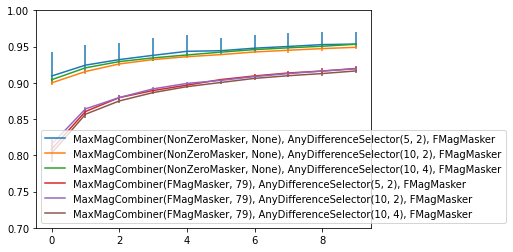

In [ ]:
# Reset weights after selecting
esweird.plot_results(ylim=[0.7, 1], loc='lower left')

In [ ]:
for c, s, p in esweird.results:
  print(c, s, p)
  l = esweird.results.get((c, s, p))
  for m in l.io.models:
    if m.refit_:
      l.evaluate(m.model, test_data=(test_images, test_labels))
  print("-----------------------------------")
  del l
  del c, s, p

MaxMagCombiner(NonZeroMasker, None) AnyDifferenceSelector(5, 2) <class 'lottery.Masker.FMagMasker'>
157/157 [==============================] - 0s 2ms/step
0.9758
157/157 [==============================] - 0s 1ms/step
0.9774
157/157 [==============================] - 0s 1ms/step
0.9858
157/157 [==============================] - 0s 2ms/step
0.9766
157/157 [==============================] - 0s 2ms/step
0.9756
-----------------------------------
MaxMagCombiner(NonZeroMasker, None) AnyDifferenceSelector(10, 2) <class 'lottery.Masker.FMagMasker'>
157/157 [==============================] - 0s 1ms/step
0.9776
157/157 [==============================] - 0s 1ms/step
0.9768
157/157 [==============================] - 0s 1ms/step
0.9754
157/157 [==============================] - 0s 1ms/step
0.9776
157/157 [==============================] - 0s 2ms/step
0.9766
-----------------------------------
MaxMagCombiner(NonZeroMasker, None) AnyDifferenceSelector(10, 4) <class 'lottery.Masker.FMagMasker'>
157/15

In [ ]:
#%%capture
lt_max4 = LotteryTicket(model=keras.models.load_model("mnist_before_training.h5"),
                   optimizer=SGD(),
                   loss=sparse_categorical_crossentropy,
                   metrics=['sparse_categorical_accuracy'],
                   combiner=MaxCombiner(4),
                   iterations=5)

lt_max4.set_pruner(FMagMasker)
lt_max4.set_pruning_percentage(percentages)
lt_max4.fit(train_images, train_labels, validation_data=(valid_images, valid_labels), epochs=epochs, test_data=(test_images, test_labels))

20
Next Step marries all weights. List of weights:  4
Next Step marries all weights. List of weights:  4
Next Step marries all weights. List of weights:  4
Next Step marries all weights. List of weights:  4
Next Step marries all weights. List of weights:  4


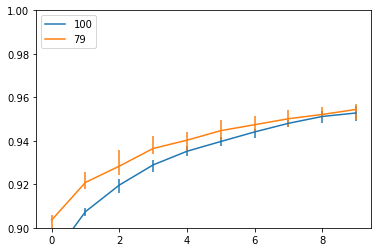

In [ ]:
lt_max4.io.plot_history(ylim=[0.9, 1])

In [ ]:
lt_max2_cutoff = LotteryTicket(model=keras.models.load_model("mnist_before_training.h5"),
                   optimizer=SGD(),
                   loss=sparse_categorical_crossentropy,
                   metrics=['sparse_categorical_accuracy'],
                   combiner=MaxCombiner(2, FMagMasker, 79),
                   iterations=5)

lt_max2_cutoff.set_pruner(FMagMasker)
lt_max2_cutoff.set_pruning_percentage(percentages)
lt_max2_cutoff.fit(train_images, train_labels, validation_data=(valid_images, valid_labels), epochs=epochs, test_data=(test_images, test_labels))

10
mnist models/mnist\10
mnist models/mnist\18
mnist models/mnist\9
mnist models/mnist\19
mnist models/mnist\6
mnist models/mnist\7
mnist models/mnist\3
mnist models/mnist\11
mnist models/mnist\0
mnist models/mnist\15
Next Step marries all weights. List of weights:  2
Next Step marries all weights. List of weights:  2
Next Step marries all weights. List of weights:  2
Next Step marries all weights. List of weights:  2
Next Step marries all weights. List of weights:  2


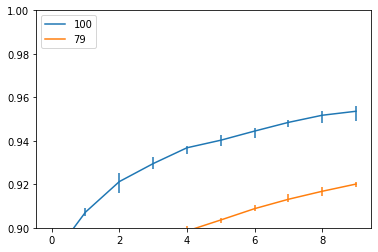

In [ ]:

lt_max2_cutoff.io.plot_history(ylim=[0.9, 1])

In [ ]:
#%%capture
lt_max4_cutoff = LotteryTicket(model=keras.models.load_model("mnist_before_training.h5"),
                   optimizer=SGD(),
                   loss=sparse_categorical_crossentropy,
                   metrics=['sparse_categorical_accuracy'],
                   combiner=MaxCombiner(4, FMagMasker, 79),
                   iterations=5)

lt_max4_cutoff.set_pruner(FMagMasker)
lt_max4_cutoff.set_pruning_percentage(percentages)
lt_max4_cutoff.fit(train_images, train_labels, validation_data=(valid_images, valid_labels), epochs=epochs, test_data=(test_images, test_labels))

20
Next Step marries all weights. List of weights:  4
Next Step marries all weights. List of weights:  4
Next Step marries all weights. List of weights:  4
Next Step marries all weights. List of weights:  4
Next Step marries all weights. List of weights:  4


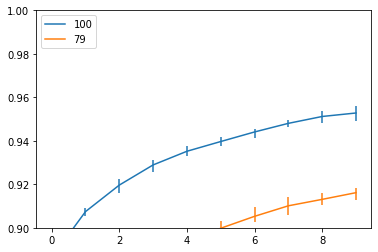

In [ ]:
lt_max4_cutoff.io.plot_history(ylim=[0.9, 1])

In [ ]:
lt_max2_of_5 = LotteryTicket(model=keras.models.load_model("mnist_before_training.h5"),
                             optimizer=SGD(),
                             loss=sparse_categorical_crossentropy,
                             metrics=["sparse_categorical_accuracy"],
                             combiner=MaxMagCombiner(),
                             selector=AnyDifferenceSelector(5, 2),
                             iterations=5)
lt_max2_of_5.set_pruner(FMagMasker)
lt_max2_of_5.set_pruning_percentage(percentage)
lt_max2_of_5.fit(train_images, train_labels, validation_data=(valid_images, valid_labels), epochs=epochs, test_data=(test_images, test_labels))

25
Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6236 - sparse_categorical_accuracy: 0.8369 - val_loss: 0.4029 - val_sparse_categorical_accuracy: 0.8824
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2925 - sparse_categorical_accuracy: 0.9158 - val_loss: 0.3239 - val_sparse_categorical_accuracy: 0.9072
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2398 - sparse_categorical_accuracy: 0.9315 - val_loss: 0.2733 - val_sparse_categorical_accuracy: 0.9196
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2045 - sparse_categorical_accuracy: 0.9415 - val_loss: 0.2448 - val_sparse_categorical_accuracy: 0.9272
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1776 - sparse_categorical_accuracy: 0.9490 - val_loss: 0.2160 - val_sparse_categorical_accuracy: 0.9368
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1566 - sp

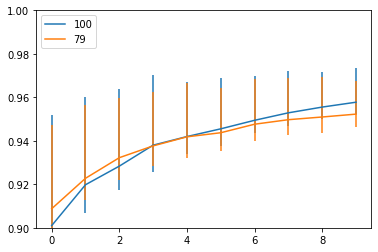

In [ ]:
lt_max2_of_5.io.plot_history(ylim=[0.9, 1])

In [ ]:
for m in lt_max2_of_5.io.models:
  if m.refit_:
    print(len(m.source_weights))

2
2
2
2
2


In [ ]:
for m in lt_max2_of_5.io.models:
  if m.refit_:
    print(weights_0_percentage(m))

del m

(784, 200)
97835  /  156800
0.6239477040816327
(200, 80)
9983  /  16000
0.6239375
(80, 10)
496  /  800
0.62
None
(784, 200)
97817  /  156800
0.6238329081632653
(200, 80)
9982  /  16000
0.623875
(80, 10)
495  /  800
0.61875
None
(784, 200)
98054  /  156800
0.625344387755102
(200, 80)
9979  /  16000
0.6236875
(80, 10)
505  /  800
0.63125
None
(784, 200)
97852  /  156800
0.6240561224489796
(200, 80)
9971  /  16000
0.6231875
(80, 10)
495  /  800
0.61875
None
(784, 200)
97857  /  156800
0.6240880102040817
(200, 80)
10005  /  16000
0.6253125
(80, 10)
503  /  800
0.62875
None


In [ ]:
def zero(ws):
  for w in ws:
    print(w.shape)
    print(sum(sum(w == 0)), " / ", (w.shape[0] * w.shape[1]))
    print(sum(sum(w == 0)) / (w.shape[0] * w.shape[1]))

In [ ]:
i = 3

"""s1 = lt_max4_cutoff.io.models[i].source_weights[0]
s2 = lt_max4_cutoff.io.models[i].source_weights[1]
s3 = lt_max4_cutoff.io.models[i].source_weights[2]
s4 = lt_max4_cutoff.io.models[i].source_weights[3]"""

print(zero(s1))
print(zero(s2))
print(zero(s3))
print(zero(s4))


del s1
del s2
del s3
del s4
del i

(784, 200)
123872  /  156800
0.79
(200, 80)
12640  /  16000
0.79
(80, 10)
632  /  800
0.79
None
(784, 200)
123872  /  156800
0.79
(200, 80)
12640  /  16000
0.79
(80, 10)
632  /  800
0.79
None
(784, 200)
123872  /  156800
0.79
(200, 80)
12640  /  16000
0.79
(80, 10)
632  /  800
0.79
None
(784, 200)
123872  /  156800
0.79
(200, 80)
12640  /  16000
0.79
(80, 10)
632  /  800
0.79
None


In [ ]:
for m in lt_max2_cutoff.io.models:
  if m.refit_:
    print(weights_0_percentage(m))
    print()

(784, 200)
123872  /  156800
0.79
(200, 80)
12640  /  16000
0.79
(80, 10)
632  /  800
0.79
None

(784, 200)
123872  /  156800
0.79
(200, 80)
12640  /  16000
0.79
(80, 10)
632  /  800
0.79
None

(784, 200)
123872  /  156800
0.79
(200, 80)
12640  /  16000
0.79
(80, 10)
632  /  800
0.79
None

(784, 200)
123872  /  156800
0.79
(200, 80)
12640  /  16000
0.79
(80, 10)
632  /  800
0.79
None

(784, 200)
123872  /  156800
0.79
(200, 80)
12640  /  16000
0.79
(80, 10)
632  /  800
0.79
None



In [ ]:
for m in lt_max4_cutoff.io.models:
  if m.refit_:
    print(weights_0_percentage(m))
    print()

(784, 200)
123872  /  156800
0.79
(200, 80)
12640  /  16000
0.79
(80, 10)
632  /  800
0.79
None

(784, 200)
123872  /  156800
0.79
(200, 80)
12640  /  16000
0.79
(80, 10)
632  /  800
0.79
None

(784, 200)
123872  /  156800
0.79
(200, 80)
12640  /  16000
0.79
(80, 10)
632  /  800
0.79
None

(784, 200)
123872  /  156800
0.79
(200, 80)
12640  /  16000
0.79
(80, 10)
632  /  800
0.79
None

(784, 200)
123872  /  156800
0.79
(200, 80)
12640  /  16000
0.79
(80, 10)
632  /  800
0.79
None



In [ ]:
s1 = lt_max4.io.models[3].source_weights[0]
s2 = lt_max4.io.models[3].source_weights[1]
s3 = lt_max4.io.models[3].source_weights[2]
s4 = lt_max4.io.models[3].source_weights[3]

In [ ]:
weights_0_percentage(lt_max4.io.models[3])

(784, 200)
62532  /  156800
0.3988010204081633
(200, 80)
6300  /  16000
0.39375
(80, 10)
315  /  800
0.39375


In [ ]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [ ]:
colors

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [ ]:
es = ExperimentSearch(keras.models.load_model("mnist_before_training_maskingsgd.h5", custom_objects={"MaskingSGD": MaskingSGD}),
                      MaskingSGD(),
                      sparse_categorical_crossentropy,
                      ['sparse_categorical_accuracy'],
                      [MaxMagCombiner()],
                      [AnyDifferenceSelector(5, 2), AnyDifferenceSelector(10, 2)],
                      [FMagMasker],
                      2,
                      percentage, "mnist", callbacks=[CheckSelectorCallback()])

es.fit(train_images, train_labels, validation_data=(valid_images, valid_labels), epochs=epochs, test_data=(test_images, test_labels))

-----------------------------------
Lottery: MaxMagCombiner(NonZeroMasker, None) AnyDifferenceSelector(5, 2, reverse=False)
10
mnist models/mnist\143
mnist models/mnist\29
mnist models/mnist\89
mnist models/mnist\25
mnist models/mnist\52
(784, 200)
97556  /  156800
0.6221683673469388
(200, 80)
9970  /  16000
0.623125
(80, 10)
486  /  800
0.6075
mnist models/mnist\23
mnist models/mnist\66
mnist models/mnist\142
mnist models/mnist\103
mnist models/mnist\123
(784, 200)
97625  /  156800
0.6226084183673469
(200, 80)
9965  /  16000
0.6228125
(80, 10)
497  /  800
0.62125
-----------------------------------
Lottery: MaxMagCombiner(NonZeroMasker, None) AnyDifferenceSelector(10, 2, reverse=False)
20
mnist models/mnist\58
mnist models/mnist\77
mnist models/mnist\7
mnist models/mnist\56
mnist models/mnist\90
mnist models/mnist\48
mnist models/mnist\78
mnist models/mnist\37
mnist models/mnist\122
mnist models/mnist\31
(784, 200)
97520  /  156800
0.621938775510204
(200, 80)
9964  /  16000
0.62275
(8

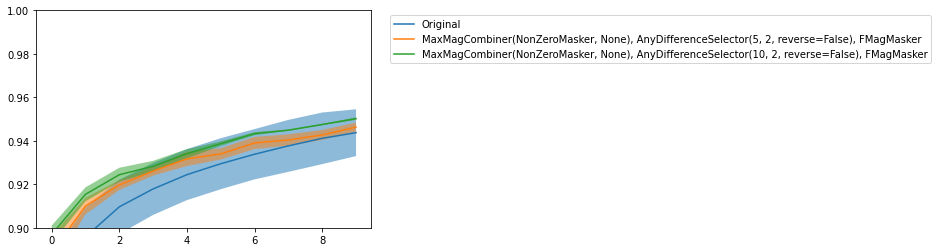

In [ ]:
es.plot_results(draw_indices=[1, ])

In [23]:
es = ExperimentSearch(keras.models.load_model("mnist_before_training_maskingsgd.h5", custom_objects={"MaskingSGD": MaskingSGD}),
                      MaskingSGD(),
                      sparse_categorical_crossentropy,
                      ['sparse_categorical_accuracy'],
                      [MaxMagCombiner()],
                      [AnyDifferenceSelector(10, 4), AnyDifferenceSelector(10, 4, True)],
                      [FMagMasker],
                      5,
                      percentage, "mnist", callbacks=[CheckSelectorCallback()])

es.fit(train_images, train_labels, validation_data=(valid_images, valid_labels), epochs=epochs, test_data=(test_images, test_labels))

-----------------------------------
Lottery: MaxMagCombiner(NonZeroMasker, None) AnyDifferenceSelector(10, 4, reverse=False)
50
mnist models/mnist\143
mnist models/mnist\52
mnist models/mnist\70
mnist models/mnist\49
mnist models/mnist\61
mnist models/mnist\133
mnist models/mnist\15
mnist models/mnist\99
mnist models/mnist\91
mnist models/mnist\124
(784, 200)
60873  /  156800
0.38822066326530613
(200, 80)
6181  /  16000
0.3863125
(80, 10)
320  /  800
0.4
mnist models/mnist\148
mnist models/mnist\26
mnist models/mnist\81
mnist models/mnist\68
mnist models/mnist\128
mnist models/mnist\55
mnist models/mnist\62
mnist models/mnist\125
mnist models/mnist\31
mnist models/mnist\131
(784, 200)
60753  /  156800
0.3874553571428571
(200, 80)
6188  /  16000
0.38675
(80, 10)
306  /  800
0.3825
mnist models/mnist\43
mnist models/mnist\96
mnist models/mnist\6
mnist models/mnist\34
mnist models/mnist\119
mnist models/mnist\32
mnist models/mnist\5
mnist models/mnist\25
mnist models/mnist\78
mnist models